# AU Mic with Disk

## Direct Imaging vs Coronagraphy

Updates:

  - 04/27/2021 with latest WebbPSF values, updated detector parameters, WFE drift values, and BEX model extrapolations.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# from IPython.display import display, Latex, clear_output
# from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

pynrc.setup_logging('WARNING', verbose=False)

In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, obs_wfe, obs_optimize
from pynrc.nb_funcs import model_info, disk_rim_model

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches
from pynrc.nb_funcs import update_yscale, do_plot_contrasts, do_plot_contrasts2
from pynrc.nb_funcs import plot_hdulist, plot_images, plot_images_swlw

## Define Sources and their Reference PSF Stars

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [5]:
# Argument list:(Name,           dist, age, sptype,  mag)
args_sources = [('AUMic',         9.72,  24,  'M1V',  4.53, bp_k)]

ref_sources  = [('TYC5899',      'M3V',  6.89, bp_k)]


In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'MDwarfs/'

In [19]:
# List of filters
args_filter = [
    ('F444W', 'CIRCLYOT', 'MASK430R'),
    ('F480M', None, None),
]

subsize = 320

filt_keys = []
for filt,pupil,mask in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

## SED Fit

In [20]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age_sci, spt_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,10])

# Final source spectrum
sp_sci = src.sp_model

[0.93422318]


In [21]:
# Do the same for the reference source
name_ref, spt_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True, wlim=[1,10])

# Final reference spectrum
sp_ref = ref.sp_model

[0.99420177]


## Generate Observations

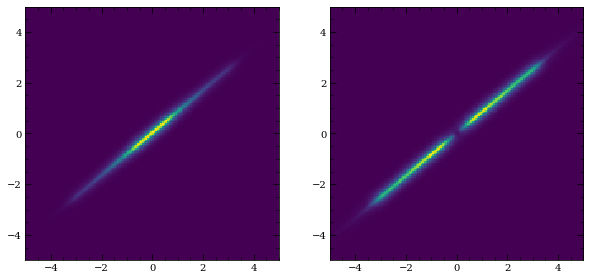

In [22]:
from astropy.io import fits
hdul = fits.open(outdir + 'AUMicdisk1mu_4.42_1000.000.fits')

# Data model
data = hdul[0].data
data_wave = 4.34 # micons
pa_offset = -40

# Arcsec/pixel
pix_asec = hdul[0].header['PIXELSCA']

# Steradians to square arcsec
sr_to_asec2 = (3600*180/np.pi)**2

# Data in Jy/pixel
data *= 1000 # mJy / pixel

# Mask inner disk region
rho = nrc_utils.dist_image(data, pixscale=pix_asec)
#data[rho<=0.1] = 0
 
hdul[0].data = nrc_utils.rotate_offset(data, pa_offset, reshape=False)

args_disk = (hdul, pix_asec, dist_sci, data_wave, 'mJy/pixel')
#hdul_out = pynrc.obs_nircam.model_to_hdulist(args_disk, sp_sci, bp)

extent = np.array([-1,1,-1,1]) * hdul[0].data.shape[0] * pix_asec / 2

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(hdul[0].data, extent=extent)
axes[1].imshow(hdul[0].data*rho, extent=extent)
for ax in axes:
    ax.set_xlim([-5,5])
    ax.set_ylim([-5,5])
#plt.xlim([-1,1])
#plt.ylim([-1,1])


In [23]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk=args_disk, 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F444W_MASK430R_CIRCLYOT
F480M_none_none


In [24]:
# if there's a disk input, then we want to remove disk 
# contributions from stellar flux and recompute to make 
# sure total flux counts matches what we computed for 
# sp_sci in previous section to match real photometry
if args_disk is not None:
    for key in filt_keys:
        obs = obs_dict[key]
        
        star_flux = obs.star_flux(sp=sp_sci) # Pass original input spectrum
        disk_flux = obs.disk_hdulist[0].data.sum()
        obs.sp_sci = sp_sci * (1 - disk_flux / star_flux)
        obs.sp_sci.name = sp_sci.name

        print(disk_flux, star_flux, obs.star_flux())

324168.36418002006 135418620.8897258 135094452.52554578
54643.9963960747 31323964.650148448 31269320.653752375


In [25]:
# Update detector readout
for key in filt_keys:
    obs = obs_dict[key]

    if 'none' in key:
        pattern, ng, nint_sci, nint_ref = ('RAPID',10,600,600)
        obs.update_detectors(xpix=160, ypix=160)
        obs.nrc_ref.update_detectors(xpix=160, ypix=160)
    elif ('MASK210R' in key) or ('MASKSWB' in key):
        pattern, ng, nint_sci, nint_ref = ('BRIGHT2',10,20,20)
    else:
        pattern, ng, nint_sci, nint_ref = ('MEDIUM8',10,17,17)

    obs.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=pattern, ngroup=ng, nint=nint_ref)
    
    print(key)
    print(obs.multiaccum_times)
    _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    print('')

F444W_MASK430R_CIRCLYOT
{'t_frame': 1.06904, 't_group': 10.6904, 't_int': 104.76592, 't_exp': 1781.02064, 't_acq': 1799.53296, 't_int_tot1': 105.85488, 't_int_tot2': 105.85488}
Point Source Sensitivity (5-sigma): 21.49 vegamag
Surface Brightness Sensitivity (5-sigma): 22.82 vegamag/arcsec^2

F480M_none_none
{'t_frame': 0.27864, 't_group': 0.27864, 't_int': 2.7864, 't_exp': 1671.84, 't_acq': 1842.12, 't_int_tot1': 3.0702, 't_int_tot2': 3.0702}
Point Source Sensitivity (5-sigma): 20.98 vegamag
Surface Brightness Sensitivity (5-sigma): 19.09 vegamag/arcsec^2



In [26]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec



F444W_MASK430R_CIRCLYOT
Sci: AUMic
  0 saturated pixel at NGROUP=2; Max Well: 0.07
  0 saturated pixel at NGROUP=10; Max Well: 0.38
  Sat Dist NG=2: 0.00 arcsec
Ref: TYC5899
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.04

F480M_none_none
Sci: AUMic
  23 saturated pixel at NGROUP=2; Max Well: 20.82
  91 saturated pixel at NGROUP=10; Max Well: 104.09
  Sat Dist NG=2: 0.28 arcsec
Ref: TYC5899
  9 saturated pixel at NGROUP=2; Max Well: 2.46
  21 saturated pixel at NGROUP=10; Max Well: 12.28


In [27]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=False,
                         opt_diff=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys, nsig=nsig, roll_angle=roll, no_ref=True, 
                          opt_diff=False)

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/3 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/3 [00:00<?, ?it/s]

Observations:   0%|          | 0/2 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/3 [00:00<?, ?it/s]

WFE Drift:   0%|          | 0/3 [00:00<?, ?it/s]

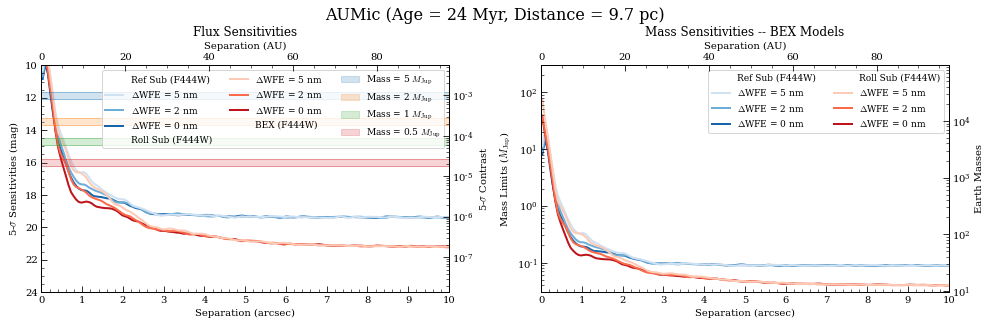

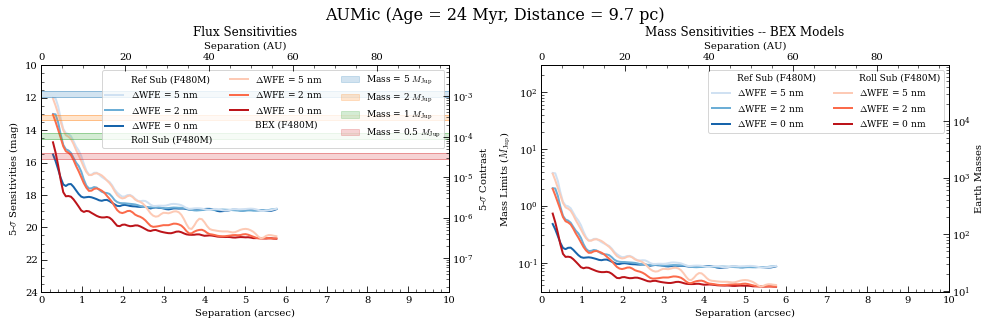

In [28]:
lin_vals = np.linspace(0.2,0.8,len(wfe_list))
c2 = plt.cm.Reds_r(lin_vals)
c1 = plt.cm.Blues_r(lin_vals)

for k in filt_keys:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    

    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, c1=c1, c2=c2, 
                                       xr=[0,10], yr=[24,10], yscale2='log', yr2=[3e-2, 300],
                                       curves_all2=curves_roll, linder_models=True, mass_list=[5,2,1,0.5])

    fig.subplots_adjust(top=0.8, bottom=0.1 , left=0.05, right=0.95)
#     fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
#     fig.savefig(outdir+fname)

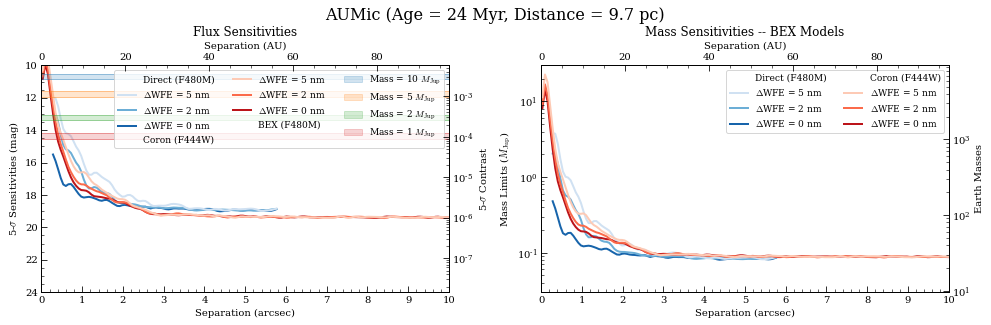

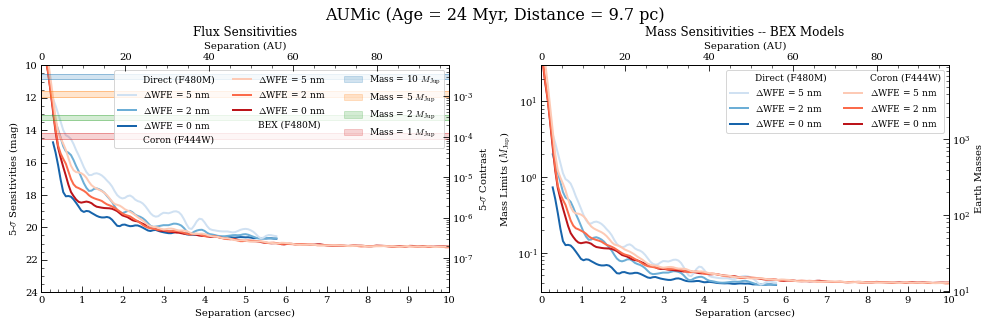

In [29]:
## HERE JUST FOR REFERENCE

# key1, key2 = ('F444W_MASK430R_CIRCLYOT', 'F444W_MASK430R_CIRCLYOT') #filt_keys[-2:][::-1]
key1, key2 = ('F480M_none_none', 'F444W_MASK430R_CIRCLYOT')
for curves in [curves_ref, curves_roll]:
    #key1 = filt_keys[0]
    #key2 = filt_keys[1]
    lab1 = 'Direct (F480M)'
    lab2 = 'Coron (F444W)'
    fig, axes_all = do_plot_contrasts2(key1, key2, curves, nsig, obs_dict, wfe_list, age_sci,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[24,10],
                                       yscale2='log', yr2=[3e-2, 30], linder_models=True)

    fname = "{}_compare.pdf".format(name_sci.replace(" ", ""))
#     fig.savefig(outdir+fname)

In [37]:
# Add a couple planets in the disk plane

# Planet masses (MEarth) and distances (arcsec)
pmass = np.array([200, 100])
# sep (asec), PA
rth_arr = [(1,130),(3,-50)] 

for key in filt_keys:
    obs = obs_dict[key]
    obs.kill_planets()
    
    filt = obs.filter
    
    tbl = nrc_utils.linder_table()
    mass_data, mag_data = nrc_utils.linder_filter(tbl, filt, age_sci, dist=dist_sci)

    # In terms of Earth masses
    mass_data_me = mass_data * 318
    isort = np.argsort(mass_data_me)

    # Interpolate in log space
    xv, yv = np.log10(mass_data_me[isort]), mag_data[isort]
    xint = np.log10(pmass)
    yint = np.interp(xint, xv, yv)

    print(yint)

    mag_vals = yint + np.array([0.5, 0.25]) # Add some extinction
    mass_arr = [1,1] # SB12 SED reference
    
    # Specify the 
    for i, mag in enumerate(mag_vals):
        obs.add_planet(rtheta=rth_arr[i], runits='asec', age=age_sci, mass=mass_arr[i], entropy=8, 
                       accr=False, renorm_args=(mag,'vegamag',obs.bandpass))

    pl_mags = []
    for pl in obs.planets:
        sp = obs.planet_spec(**pl)
        renorm_args = pl['renorm_args']
        sp_norm = sp.renorm(*renorm_args)
        sp_norm.name = sp.name
        sp = sp_norm

        o = S.Observation(sp, obs.bandpass, binset=obs.bandpass.wave)
        pl_mags.append(o.effstim('vegamag'))
        
    print('Planet Mags:', key, pl_mags)

[15.32966092 16.6850162 ]
Planet Mags: F444W_MASK430R_CIRCLYOT [15.829660919908488, 16.935016204872852]
[15.01132084 16.27897511]
Planet Mags: F480M_none_none [15.51132084397767, 16.52897511092686]


In [43]:
# Roll Subtracted
wfe_ref = 5
wfe_roll = 2

hdul_ref = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=False, opt_diff=False,
                       oversample=4, PA1=60, PA2=70)

hdul_roll = do_gen_hdus(obs_dict, filt_keys, wfe_ref, wfe_roll, no_ref=True, opt_diff=False,
                        oversample=4, PA1=60, PA2=70)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [44]:
hdul_ref.keys()

dict_keys(['F444W_MASK430R_CIRCLYOT', 'F480M_none_none'])

In [45]:
vmax_arr = []
for key in filt_keys:
    obs = obs_dict[key]
    im = obs.gen_disk_image()
    vmax_arr.append(im.max()/4)

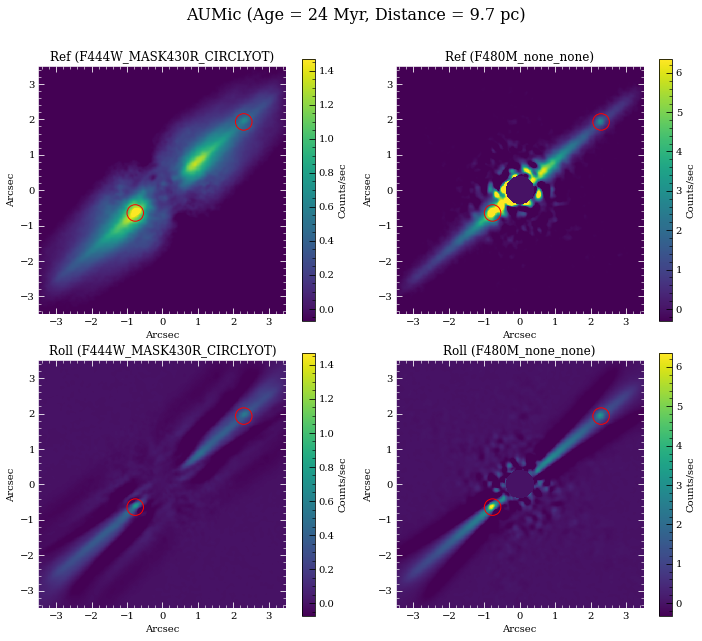

In [46]:
from copy import deepcopy
fig, axes = plt.subplots(2,2, figsize=(10,9))

for i, ax in enumerate(axes[0]):
    key = filt_keys[i]
    hdul = deepcopy(hdul_ref[key])
    
    data = hdul[0].data
    header = hdul[0].header
    pixscale = header['PIXELSCL']
    rho = nrc_utils.dist_image(data, pixscale=pixscale)
    
    if i==1:
        data[rho<0.4] = 0
        
    vmin, vmax = (-vmax_arr[i]/100, vmax_arr[i]/5)
    #ax.imshow(data, extent=extent, vmin=vmin, vmax=vmax)
    plot_hdulist(hdul, ax=ax, vmin=vmin, vmax=vmax, half_pix_shift=False)
    
    ax.set_title('Ref ({})'.format(key))

    
for i, ax in enumerate(axes[1]):
    key = filt_keys[i]
    hdul = deepcopy(hdul_roll[key])
    
    data = hdul[0].data
    header = hdul[0].header
    pixscale = header['PIXELSCL']
    rho = nrc_utils.dist_image(data, pixscale=pixscale)
    
    if i==1:
        data[rho<0.4] = 0
    
    vmin, vmax = (-vmax_arr[i]/100, vmax_arr[i]/5)
    #ax.imshow(data, extent=extent, vmin=vmin, vmax=vmax)
    plot_hdulist(hdul, ax=ax, vmin=vmin, vmax=vmax, half_pix_shift=False)

    ax.set_title('Roll ({})'.format(key))
    
fov=7

# Location of planet
for pl in obs.planets:
    loc = (np.array(pl['xyoff_pix'])) * obs.pix_scale
    for ax in axes.flatten():
        circle = matplotlib.patches.Circle(loc, radius=fov/30., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle);
    

for ax in axes.flatten():
    ax.set_xlim([-fov/2,fov/2])
    ax.set_ylim([-fov/2,fov/2])
    
# Title
dist = obs.distance
age_str = 'Age = {:.0f} Myr'.format(age_sci)
dist_str = 'Distance = {:.1f} pc'.format(dist)
title_str = '{} ({}, {})'.format(name_sci,age_str,dist_str)

fig.suptitle(title_str, fontsize=16);

fig.tight_layout()
fig.subplots_adjust(top=0.9)

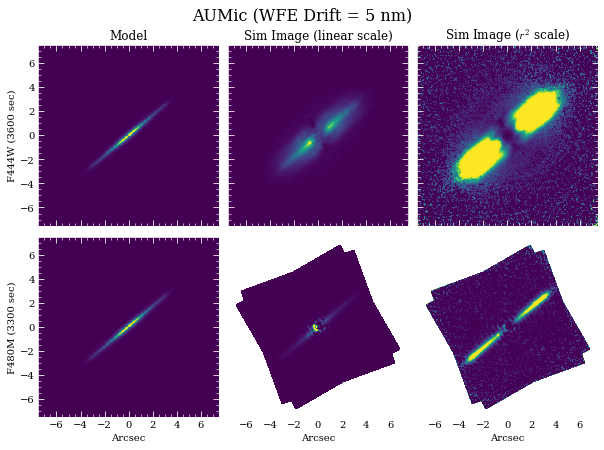

In [52]:
save_fig = False
fov = 15

plot_images(obs_dict, hdul_ref, filt_keys, wfe_ref, fov=fov, save_fig=save_fig, outdir=outdir)

# plot_images(obs_dict, hdul_roll, filt_keys, wfe_roll, fov=fov, save_fig=save_fig, outdir=outdir)